In [2]:
#!pip install sklearn

In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
base_path = "/int_data/house-count"

import albumentations as A



transform_albumentations = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.ISONoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),            
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),            
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])


class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None, transform_album=None):

        self.data_df = data_df
        self.transform = transform
        self.transform_album = transform_album

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['img_num'], self.data_df.iloc[idx]['number_of_houses']

        # читаем картинку. read the image
        image = cv2.imread(f"{base_path}/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform_album:
            image = self.transform_album(image=image)['image']
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [3]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [4]:
# читаем датасет
data_df = pd.read_csv(base_path+"/train.csv")

In [5]:
# Нам придется вычесть 1 что индексы классов начинались с 0.
data_df.number_of_houses = data_df.number_of_houses- 1
# Главное потом не забыть прибавить ее обратно

In [6]:
data_df.head(3)

,img_num,number_of_houses
0,000000000611.jpg,8
1,000000000530.jpg,9
2,000000002787.jpg,9


In [7]:
from os import listdir

print("Обучающей выборки " ,len(listdir(base_path+"/train")))
print("Тестовой выборки " ,len(listdir(base_path+"/test")))

Обучающей выборки  2100
Тестовой выборки  900


<AxesSubplot:xlabel='number_of_houses', ylabel='count'>

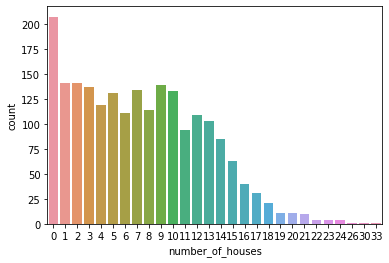

In [8]:
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
sns.countplot(x = "number_of_houses" , data  = data_df)

Обратим внимание, что после 24 домов идет 26 и 30. В данных идут пропуски которые могут вызвать вызвать ошибки у CUDA. Выкинем такие данные.

In [9]:
data_df = data_df[data_df.number_of_houses < 25]

In [10]:
data_df.number_of_houses.unique()

array([ 8,  9,  1,  2, 10, 11,  5, 15, 16,  0, 14,  3,  6,  7, 20, 13, 12,
        4, 17, 21, 19, 18, 24, 22, 23])

<AxesSubplot:xlabel='number_of_houses', ylabel='count'>

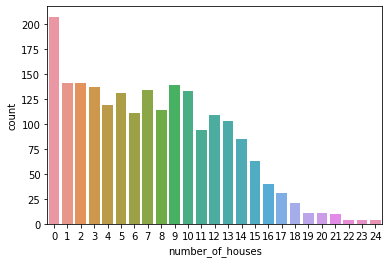

In [11]:
sns.countplot(x = "number_of_houses" , data  = data_df)

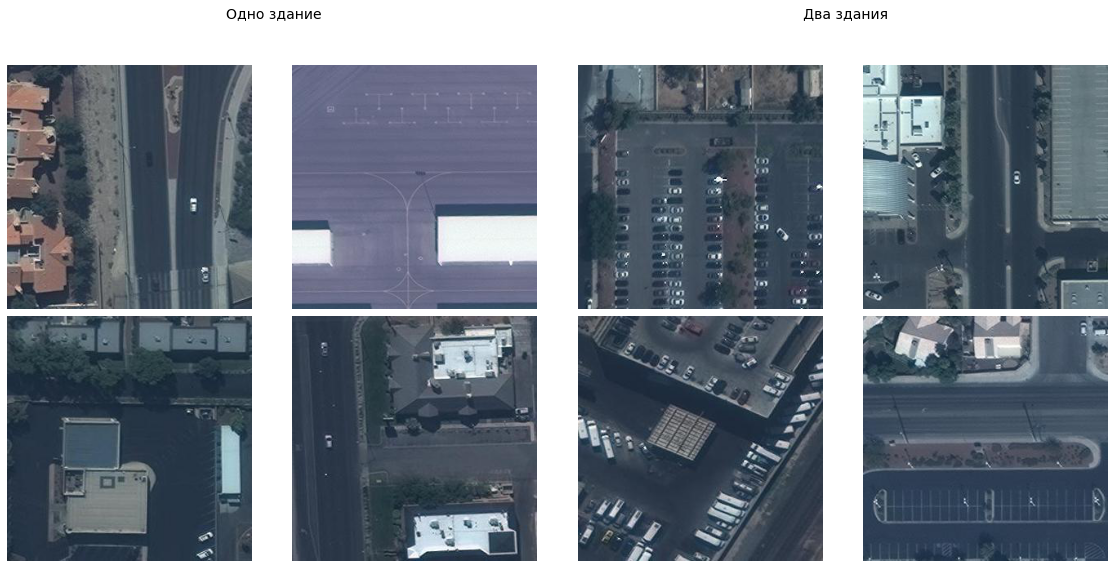

In [12]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Одно здание {" "*105} Два здания', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 1 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"{base_path}/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['number_of_houses'] == 2 ].sample(4, random_state=42)['img_num']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"{base_path}/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [13]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [14]:
train_df.shape, valid_df.shape

((1677, 2), (420, 2))

In [15]:
train_dataset = ImageDataset(train_df, train_transform, transform_albumentations)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=24,
                                           shuffle=True,
                                           pin_memory=True,                                           
                                           num_workers=1)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=24,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

## Вспомогательные функции

In [17]:
def crossvalid(res_model=None,criterion=None,optimizer=None, sheduler=None, batch_size = 30, dataset=None, k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    val_loss = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [18]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [19]:
def train(res_model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    best_model_attr = None
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()            

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        
        
        

        print("learning rate:", optimizer.param_groups[0]["lr"])
        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
        if best_model_attr is None or best_model_attr[0] > (val_loss / val_size)*100 :
            best_model_attr = ((val_loss / val_size)*100, optimizer.param_groups[0]["lr"], copy.deepcopy(model))
           
        
        
        scheduler.step()
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log, best_model_attr

## Модель

In [20]:
metrics = [] 

from sklearn.metrics import r2_score

params_m = [0.85, 0.89, 0.9, 0.95, 0.98]
params_i = [ [4,6,8,12,16,20],            
    [4,8,16,20],
    [6, 12, 18,14],
    [6,18,20,23]        
]

for m1 in (params_m):
    for interval in (params_i):
    
        torch.cuda.empty_cache()
        torch.manual_seed(0)
    
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, 25)
    
        model = model.cuda()
        criterion = torch.nn.CrossEntropyLoss()
    
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum = m1)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=interval, gamma = 0.5)
        
        train_loss_log, train_acc_log, val_loss_log, val_acc_log, best_model_attr = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 scheduler,
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 25)
        model.eval()
        valid_predicts = []

        for imgs, label in valid_loader:
    
            imgs = imgs.cuda()
            pred = model(imgs)

            pred_numpy = pred.cpu().detach().numpy()

            for class_obj in pred_numpy:
                index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
                valid_predicts.append(index)
        
        valid_df["pred"] = valid_predicts
        valid_df['diff'] = valid_df['number_of_houses']-valid_df['pred']
        r2 = r2_score(valid_df['number_of_houses'].values, valid_df['pred'].values)
        print(r2, interval, m1)
        metrics.append((r2, interval, m1))
    

  0%|          | 0/25 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [22]:
for v in metrics:
    print(v)

(0.7924624806620647, [4, 6, 8, 12, 16, 20], 0.85)
(0.7738436840707428, [4, 8, 16, 20], 0.85)
(0.7793051977375305, [6, 12, 18, 14], 0.85)
(0.7755814384192662, [6, 18, 20, 23], 0.85)
(0.8101710249755887, [4, 6, 8, 12, 16, 20], 0.89)
(0.8105847760109515, [4, 8, 16, 20], 0.89)
(0.7908902267276864, [6, 12, 18, 14], 0.89)
(0.7902282250711061, [6, 18, 20, 23], 0.89)
(0.8124880307736199, [4, 6, 8, 12, 16, 20], 0.9)
(0.7945312358388783, [4, 8, 16, 20], 0.9)
(0.7666444160554317, [6, 12, 18, 14], 0.9)
(0.7853459628538261, [6, 18, 20, 23], 0.9)
(0.8149705369857961, [4, 6, 8, 12, 16, 20], 0.95)
(0.8075230183492673, [4, 8, 16, 20], 0.95)
(0.781208452500199, [6, 12, 18, 14], 0.95)
(0.7926279810762098, [6, 18, 20, 23], 0.95)
(0.5319648287977026, [4, 6, 8, 12, 16, 20], 0.98)
(0.6437603585527067, [4, 8, 16, 20], 0.98)
(0.5334543325250083, [6, 12, 18, 14], 0.98)
(0.7284138203879172, [6, 18, 20, 23], 0.98)


In [123]:
torch.cuda.empty_cache()
torch.manual_seed(0)

# Подргружаем модель

lr_0 = 1.0

#lr_0 = 0.1
#model = torch.load('best_model.pth')

model = models.resnet50(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False
model.fc = nn.Linear(2048, 25)

#def init_weights(m):
#    if type(m) == nn.Linear:
#        torch.nn.init.xavier_uniform(m.weight)

# Applying it to our net
#model.apply(init_weights)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [126]:
#optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01*lr_0, momentum=0.95)
# 0.8033 - 0.8290  (30)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,20], gamma=0.5)

# 0.8201 - 0.8197 (40)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,20], gamma=0.5)

# 0.8076 - 0.8244 (25)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 6, 8, 12, 16, 20], gamma = 0.5)

# 0.7739 - 0.7959
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,16,20], gamma=0.5)

# 0.78625 - 0.7872
#LR_rule = lambda epoch: 0.98 ** epoch
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = LR_rule)

#0.8201 - 0.8197 (32)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,8,12], gamma=0.5)


def scheduler_custom_func(milestone, gamma=0.5, cycle = 10):
    def calc_lr(epoch):
        e = epoch % 10 +1        
        e1 = 1
        for v in milestone:
            if v <= e:
                e1 = e1*gamma
        return e1
        
    return calc_lr


scheduler_instance = scheduler_custom_func ([4,6,8], gamma = 0.5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = scheduler_instance)

In [127]:
#scheduler_instance = scheduler_custom_func ([4,6,8], gamma = 0.5)
#for e in range(40):
#    print(0.01*sc(e))

In [128]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log, best_model_attr = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 scheduler,
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 30)

  0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 7.79 GiB total capacity; 6.23 GiB already allocated; 11.81 MiB free; 6.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

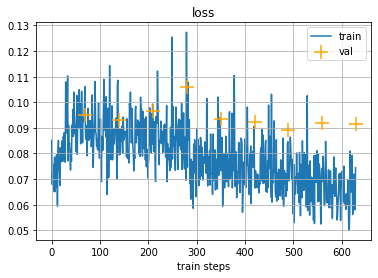

In [91]:
plot_history(train_loss_log, val_loss_log)

In [92]:
#print("valid loss:", best_model_attr[0], " lr:", best_model_attr[1])
#best_model = best_model_attr[2]
#torch.save(best_model, 'best_model.pth')
#curr_model = model.to('cpu')
#torch.cuda.empty_cache()
#model = best_model
#model.to("cuda:0")

## Посмотрим метрики нашей итоговой модели на валидации.

In [93]:
model.eval()
valid_predicts = []

for imgs, label in valid_loader:
    
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 7.79 GiB total capacity; 6.22 GiB already allocated; 11.81 MiB free; 6.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [94]:
valid_df["pred"] = valid_predicts
valid_df['diff'] = valid_df['number_of_houses']-valid_df['pred']
from sklearn.metrics import r2_score
print(r2_score(valid_df['number_of_houses'].values, valid_df['pred'].values))

ValueError: Length of values (24) does not match length of index (420)

<AxesSubplot:xlabel='diff', ylabel='count'>

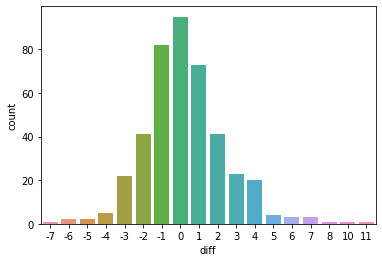

In [83]:
sns.countplot(x = "diff" , data  = valid_df)

In [76]:
print(valid_df['diff'].value_counts()/valid_df.shape[0] )

 0     0.221429
 1     0.195238
-1     0.190476
 2     0.102381
 4     0.066667
-2     0.059524
 3     0.057143
-3     0.045238
-4     0.019048
 5     0.011905
 8     0.007143
-5     0.004762
 7     0.004762
-7     0.002381
 6     0.002381
 11    0.002381
-6     0.002381
 10    0.002381
 9     0.002381
Name: diff, dtype: float64


# Посчитаем accuracy

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score

In [33]:
valid_df['pred'].values

array([16,  1,  6,  0,  9,  3, 17, 12,  4,  5,  6,  5,  9,  0, 13, 10, 10,
        5,  0,  6, 10, 13,  6,  2,  3,  6,  5,  7,  3, 15,  1,  7,  2,  0,
        0, 15, 11,  0, 13, 10, 10,  5,  5, 11,  7,  9, 10, 10,  0, 17, 14,
        3,  9,  0, 13,  5,  2,  0,  6,  9,  9, 13,  2,  7,  5, 13,  1,  3,
        6,  3, 13, 17,  0,  7, 13, 10, 11,  6,  9, 17,  5,  6,  5,  7, 13,
        2,  1,  3,  7,  0, 10, 10,  7, 13,  1,  2, 10,  0,  1,  0, 17, 13,
        0, 16,  6,  4,  3, 10,  1, 12, 13, 16, 10,  2, 14,  0,  3,  3, 13,
        0,  3, 10,  0, 11,  8,  0, 14,  1, 11,  9, 13,  0, 13,  5, 16, 10,
       10,  0,  5,  3, 10,  2,  3, 13,  1,  0, 10,  1,  3,  6,  3, 10,  2,
        2, 10,  5,  7,  5, 13,  2,  5,  4, 10,  5, 13,  0, 10,  0, 10, 13,
        8, 10,  3, 15,  7, 11,  7,  2, 13,  0,  1,  3, 10, 10,  9, 10, 10,
        5,  0, 11,  3, 17,  5,  5, 10, 10,  8, 13,  3, 14,  0,  6,  3, 10,
        3, 15, 10,  2, 14,  3, 13,  0,  5,  5, 13,  7, 13,  7,  2, 16, 15,
       14, 10,  6,  4, 10

In [34]:
val_accuracy = accuracy_score(valid_df['number_of_houses'].values, valid_df['pred'].values)
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.23333333333333334


In [35]:
test_df = pd.read_csv(base_path+"/sample_solution.csv")
test_df = test_df.drop(["number_of_houses"], axis = 1)

In [36]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['img_num']
        
        # читаем картинку
        image = cv2.imread(f"{base_path}/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [37]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [38]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [39]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    pred_numpy = pred.cpu().detach().numpy()
    
    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)
    
    #predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

100%|██████████| 900/900 [00:10<00:00, 86.04it/s]


In [40]:
#for a, b in zip(test_df['img_num'].values.tolist(), predicts):
#    print(a,b)


[(name, pred) for name, pred in zip(test_df["img_num"].values.tolist(), predicts)]

[('000000001801.jpg', 4),
 ('000000001190.jpg', 0),
 ('000000001817.jpg', 15),
 ('000000000251.jpg', 13),
 ('000000002505.jpg', 3),
 ('000000001117.jpg', 8),
 ('000000001411.jpg', 13),
 ('000000002113.jpg', 13),
 ('000000000408.jpg', 7),
 ('000000002579.jpg', 16),
 ('000000002254.jpg', 17),
 ('000000000052.jpg', 13),
 ('000000000644.jpg', 3),
 ('000000001763.jpg', 7),
 ('000000002776.jpg', 3),
 ('000000000900.jpg', 5),
 ('000000001073.jpg', 10),
 ('000000000472.jpg', 6),
 ('000000002738.jpg', 0),
 ('000000002546.jpg', 14),
 ('000000000044.jpg', 6),
 ('000000000289.jpg', 12),
 ('000000000912.jpg', 10),
 ('000000002083.jpg', 4),
 ('000000001360.jpg', 3),
 ('000000002895.jpg', 13),
 ('000000002603.jpg', 7),
 ('000000001226.jpg', 3),
 ('000000000296.jpg', 9),
 ('000000001241.jpg', 1),
 ('000000001005.jpg', 9),
 ('000000001665.jpg', 2),
 ('000000000746.jpg', 12),
 ('000000002851.jpg', 10),
 ('000000000291.jpg', 15),
 ('000000000781.jpg', 6),
 ('000000002144.jpg', 10),
 ('000000000322.jpg', 

In [ ]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

image = cv2.imread(f'{base_path}/test/000000001298.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [42]:
data_1 = [(name, pred) for name, pred in zip(test_df["img_num"].values.tolist(), predicts)]
submit_df = pd.DataFrame(data_1, columns=['img_num', 'number_of_houses'])
print(submit_df)

              img_num  number_of_houses
0    000000001801.jpg                 4
1    000000001190.jpg                 0
2    000000001817.jpg                15
3    000000000251.jpg                13
4    000000002505.jpg                 3
..                ...               ...
895  000000002443.jpg                10
896  000000000856.jpg                 3
897  000000001983.jpg                 4
898  000000000166.jpg                 1
899  000000000059.jpg                 7

[900 rows x 2 columns]


In [43]:
#Не забываем добавить 1 к предсказываемому лейблу
submit_df.number_of_houses = submit_df.number_of_houses + 1

In [44]:
submit_df.to_csv("submit.csv", index=False)

In [45]:
submit_df.head()

,img_num,number_of_houses
0,000000001801.jpg,5
1,000000001190.jpg,1
2,000000001817.jpg,16
3,000000000251.jpg,14
4,000000002505.jpg,4


In [46]:
torch.save(model, 'best_model-1.pth')